## Домашняя работа №6
**Тема: деревья решений и ансамбли (bagging / random forest / boosting / stacking) и честный ML-эксперимент.**

#### 0. Импорт необходимых библиотек и вспомогательные функции

In [199]:
# Для работы с данными
import pandas as pd
import numpy as np

import json
import joblib

# Для графиков
import matplotlib.pyplot as plt

# Разбиение на train/test и метрики качества
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, 
    roc_auc_score, confusion_matrix,
    precision_score, recall_score,
    roc_curve, precision_recall_curve,
    RocCurveDisplay, PrecisionRecallDisplay,
    ConfusionMatrixDisplay,
    )

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.tree import (
    DecisionTreeClassifier, plot_tree
    )

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance


RANDOM_STATE = 39  # начало генератора случайных чисел для воспроизводимости результата
MAX_ITER = 5000  # максимальное число итераций для логистической регрессии
models_dict = dict()  # словарь всех моделей
METRIC = "roc_auc"  # метрика для сравнения

Функция для оценки качества работы модели (только для бинарной классификации)

In [200]:
def rate_classifier(model, X_test, y_test, model_name="Model", random_state=RANDOM_STATE):
    """
    Оценка качества бинарного классификатора
    
    Parameters:
    -----------
    model : обученная модель sklearn
    X_test : тестовые признаки
    y_test : тестовые таргеты
    model_name : str, имя модели
    random_state : int
    
    Returns:
    --------
    metrics : dict, словарь с метриками
    figures : dict, словарь с фигурами matplotlib.figure.Figure
              Ключи: 'main', 'confusion_matrix', 'roc_curve', 'pr_curve', 'metrics_table'
    """
    
    # 1. Предсказания
    y_pred = model.predict(X_test)
    
    # 2. Базовые метрики
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics['precision'] = precision_score(y_test, y_pred, zero_division=0)
    metrics['recall'] = recall_score(y_test, y_pred, zero_division=0)
    metrics['f1'] = f1_score(y_test, y_pred, zero_division=0)
    
    # 3. Словарь для фигур
    figures = {}
    
    # 4. Создаем основную фигуру 2x2
    fig_main, axes_main = plt.subplots(2, 2, figsize=(14, 10))
    
    # 5. Confusion Matrix (основная фигура и отдельная)
    cm = confusion_matrix(y_test, y_pred)
    metrics['confusion_matrix'] = cm
    
    # Отдельная фигура для confusion matrix
    fig_cm, ax_cm = plt.subplots(figsize=(6, 5))
    ConfusionMatrixDisplay(cm, display_labels=['Class 0', 'Class 1']).plot(
        ax=ax_cm, cmap="Blues", colorbar=False
    )
    ax_cm.set_title(f'Матрица ошибок: {model_name}')
    ax_cm.grid(False)
    plt.tight_layout()
    figures['confusion_matrix'] = fig_cm
    plt.close(fig_cm)
    
    # Confusion matrix на основной фигуре
    ConfusionMatrixDisplay(cm, display_labels=['Class 0', 'Class 1']).plot(
        ax=axes_main[0, 0], cmap="Blues", colorbar=False
    )
    axes_main[0, 0].set_title(f'Матрица ошибок: {model_name}')
    axes_main[0, 0].grid(False)
    
    # 6. ROC и PR кривые (если доступно predict_proba)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        metrics['roc_auc'] = roc_auc_score(y_test, y_proba)
        
        # ROC кривая (отдельная фигура)
        fig_roc, ax_roc = plt.subplots(figsize=(6, 5))
        RocCurveDisplay.from_predictions(y_test, y_proba, ax=ax_roc, name=model_name)
        ax_roc.set_title(f'ROC кривая: {model_name}\nAUC = {metrics["roc_auc"]:.4f}')
        ax_roc.grid(True, alpha=0.3)
        plt.tight_layout()
        figures['roc_curve'] = fig_roc
        plt.close(fig_roc)
        
        # ROC кривая на основной фигуре
        RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes_main[0, 1], name=model_name)
        axes_main[0, 1].set_title(f'ROC кривая: {model_name}')
        axes_main[0, 1].grid(True, alpha=0.3)
        
        # PR кривая (отдельная фигура)
        fig_pr, ax_pr = plt.subplots(figsize=(6, 5))
        PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=ax_pr, name=model_name)
        
        ax_pr.set_title(f'PR кривая: {model_name}')
        ax_pr.grid(True, alpha=0.3)
        ax_pr.legend()
        plt.tight_layout()
        figures['pr_curve'] = fig_pr
        plt.close(fig_pr)
        
        # PR кривая на основной фигуре
        PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes_main[1, 0], name=model_name)
        axes_main[1, 0].set_title(f'PR кривая: {model_name}')
        axes_main[1, 0].grid(True, alpha=0.3)
        axes_main[1, 0].legend()
        
    else:
        metrics['roc_auc'] = None
        
        # Заглушки для ROC кривой
        fig_roc, ax_roc = plt.subplots(figsize=(6, 5))
        ax_roc.text(0.5, 0.5, 'ROC кривая недоступна\n(нет predict_proba)', 
                    ha='center', va='center', fontsize=12)
        ax_roc.set_title(f'ROC кривая: {model_name}')
        ax_roc.grid(True, alpha=0.3)
        plt.tight_layout()
        figures['roc_curve'] = fig_roc
        plt.close(fig_roc)
        
        axes_main[0, 1].text(0.5, 0.5, 'ROC кривая недоступна\n(нет predict_proba)', 
                           ha='center', va='center', fontsize=12)
        axes_main[0, 1].set_title(f'ROC кривая: {model_name}')
        axes_main[0, 1].grid(True, alpha=0.3)
        
        # Заглушки для PR кривой
        fig_pr, ax_pr = plt.subplots(figsize=(6, 5))
        ax_pr.text(0.5, 0.5, 'PR кривая недоступна\n(нет predict_proba)', 
                   ha='center', va='center', fontsize=12)
        ax_pr.set_title(f'PR кривая: {model_name}')
        ax_pr.grid(True, alpha=0.3)
        plt.tight_layout()
        figures['pr_curve'] = fig_pr
        plt.close(fig_pr)
        
        axes_main[1, 0].text(0.5, 0.5, 'PR кривая недоступна\n(нет predict_proba)', 
                           ha='center', va='center', fontsize=12)
        axes_main[1, 0].set_title(f'PR кривая: {model_name}')
        axes_main[1, 0].grid(True, alpha=0.3)
    
    # 7. Таблица метрик (отдельная фигура)
    fig_metrics, ax_metrics = plt.subplots(figsize=(6, 5))
    ax_metrics.axis('off')
    
    rows = [
        ['Accuracy', f"{metrics['accuracy']:.4f}"],
        ['Precision', f"{metrics['precision']:.4f}"],
        ['Recall', f"{metrics['recall']:.4f}"],
        ['F1-score', f"{metrics['f1']:.4f}"]
    ]
    
    if metrics['roc_auc'] is not None:
        rows.append(['ROC-AUC', f"{metrics['roc_auc']:.4f}"])
    
    # Рисуем таблицу (отдельная фигура)
    table = ax_metrics.table(
        cellText=rows,
        colLabels=['Метрика', 'Значение'],
        cellLoc='center',
        loc='center'
    )
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Подсветка лучших метрик
    for i, (key, _) in enumerate(rows):
        cell = table[(i + 1, 1)]  # Берем ячейку со значением
        cell.set_text_props(fontweight='bold')
    
    ax_metrics.set_title(f'Метрики качества: {model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    figures['metrics_table'] = fig_metrics
    plt.close(fig_metrics)
    
    # Таблица метрик на основной фигуре
    axes_main[1, 1].axis('off')
    table_main = axes_main[1, 1].table(
        cellText=rows,
        colLabels=['Метрика', 'Значение'],
        cellLoc='center',
        loc='center'
    )
    
    table_main.auto_set_font_size(False)
    table_main.set_fontsize(11)
    table_main.scale(1, 1.8)
    
    # Подсветка на основной фигуре
    for i in range(len(rows)):
        cell = table_main[(i + 1, 1)]
        cell.set_text_props(fontweight='bold')
    
    axes_main[1, 1].set_title('Метрики качества', fontsize=12, fontweight='bold', pad=20)
    
    # Завершаем основную фигуру
    plt.tight_layout()
    figures['main'] = fig_main
    plt.close(fig_main)
    
    return metrics, figures

Функция для вывода метрик

In [201]:
def print_metrics(metrics, model_name):
    """
    Выводит метрики классификации и матрицу ошибок.
    
    Parameters:
    -----------
    metrics_dict : dict
        Словарь с метриками вида {'metric_name': value}
        Может содержать ключ 'confusion_matrix' с матрицей ошибок
    model_name : str
        Название модели для заголовка
    """
    print("=" * 50)
    print(f"МЕТРИКИ МОДЕЛИ: {model_name}")
    print("=" * 50)
    
    # Сначала выводим основные метрики
    basic_metrics = {}
    confusion_matrix = None
    
    for metric, value in metrics.items():
        if metric == 'confusion_matrix':
            confusion_matrix = value
        else:
            basic_metrics[metric] = value
    
    # Форматируем и выводим основные метрики
    if basic_metrics:
        max_name_len = max(len(metric) for metric in basic_metrics.keys())
        
        for metric, value in basic_metrics.items():
            if isinstance(value, (int, float)):
                if 0 <= value <= 1:  # Метрики в диапазоне [0, 1]
                    formatted_value = f"{value:.4f}"
                else:
                    formatted_value = f"{value:.2f}"
            else:
                formatted_value = str(value)
            
            metric_padded = metric.ljust(max_name_len)
            print(f"{metric_padded}: {formatted_value}")
    
    # Выводим матрицу ошибок, если она есть
    if confusion_matrix is not None:
        print("\nМатрица ошибок (Confusion Matrix):")
        print("-" * 30)
        
        # Определяем размеры для красивого форматирования
        if hasattr(confusion_matrix, 'shape'):
            # Для numpy array
            rows, cols = confusion_matrix.shape
            max_val_len = max(len(str(int(v))) for v in confusion_matrix.flatten())
            
            # Заголовки
            print(" " * (max_val_len + 2) + "| Прогноз 0 | Прогноз 1")
            print("-" * (max_val_len + 25))
            
            # Строки матрицы
            for i in range(rows):
                row_label = f"Истина {i}"
                print(f"{row_label.ljust(max_val_len + 2)}|", end="")
                for j in range(cols):
                    val = int(confusion_matrix[i, j])
                    print(f" {str(val).rjust(max_val_len)} ", end="")
                print()
        else:
            # Для списка или другого формата
            print(str(confusion_matrix))
    
    print("=" * 50)

Функция для сериализации метрик

In [202]:
def serialize_metrics(metrics):
    """Преобразует метрики в JSON-сериализуемый формат"""
    serialized = {}
    for key, value in metrics.items():
        if isinstance(value, np.ndarray):
            serialized[key] = value.tolist()
        elif isinstance(value, (np.integer, np.floating)):
            serialized[key] = float(value)
        elif hasattr(value, 'tolist'):  # Для numpy скаляров
            serialized[key] = float(value)
        else:
            serialized[key] = value
    return serialized

Функция для нахождения лучшей модели

In [203]:
def find_best_model(models_dict, metric=METRIC):
    """
    Находит лучшую модель среди всех сохраненных моделей по заданной метрике.
    
    Функция перебирает все модели в словаре `models_dict` и определяет модель
    с максимальным значением указанной метрики. Полезно для автоматического
    выбора оптимальной модели для продакшена или дальнейшего анализа.
    
    Parameters
    ----------
    models_dict : dict
        Словарь с моделями в формате:
        {
            'model_name': {
                'model': объект модели,
                'metrics': dict с метриками,
                'figures': dict с графиками,
                'params': dict с параметрами,
                ...
            },
            ...
        }
    
    metric : str, default='f1'
        Название метрики, по которой определяется лучшая модель.
        Допустимые значения: 'accuracy', 'precision', 'recall', 'f1', 'roc_auc'.
        Для несбалансированных данных рекомендуется использовать 'f1'.
    
    Returns
    -------
    best_model_name : str or None
        Имя лучшей модели. Возвращает None, если модели не найдены.
    
    best_model_data : dict or None
        Данные лучшей модели (весь словарь для этой модели).
    
    best_score : float
        Значение метрики для лучшей модели. Возвращает -1, если модели не найдены.
    """
    best_model_name = None
    best_score = -1
    best_model_data = None
    
    for model_name, model_data in models_dict.items():
        if metric in model_data['metrics']:
            score = model_data['metrics'][metric]
            if score is not None and score > best_score:
                best_score = score
                best_model_name = model_name
                best_model_data = model_data
    
    return best_model_name, best_model_data, best_score

#### 1. Загрузка данных и первичный анализ

Загрузим данные из учебного датасета `S06-hw-dataset-04.csv`

In [204]:
dataSet = pd.read_csv(filepath_or_buffer="S06-hw-dataset-04.csv", sep=",")
dataSet.head()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
0,1,-1.250210,1.423474,-0.225004,-4.023138,-0.832729,-0.550874,1.772090,2.761690,-0.698750,...,10.938269,0.501178,1.600001,0.314212,1.209735,1.355697,-5.338924,1.153944,-0.153934,0
1,2,0.074328,0.376429,0.212831,-0.502074,2.017405,0.625496,1.943785,1.242030,-0.524090,...,7.775262,-4.550195,6.272586,-0.932162,-0.228543,1.735220,-3.827828,0.292165,0.273720,0
2,3,0.638481,0.060968,0.746760,2.479653,-0.292858,-0.078139,-2.918423,-0.013186,1.009135,...,-4.448447,-9.593179,-3.093519,0.029321,0.605511,0.829103,-0.085985,2.891408,0.766221,0
3,4,1.712916,-1.350969,-0.256473,1.622074,-0.445141,0.911932,-3.440345,1.505192,-1.104348,...,-1.619072,-3.237479,-5.474038,-1.582475,0.198137,3.823409,0.880395,1.148610,0.136732,0
4,5,0.905676,-0.206545,-0.068806,4.086026,-1.010045,-0.772644,-4.207688,2.506104,1.589143,...,-2.396844,-10.540129,-5.532811,-1.231203,0.000119,4.298572,-1.558235,0.924673,0.111668,0


Информация о столбцах датасета

In [205]:
dataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      25000 non-null  int64  
 1   f01     25000 non-null  float64
 2   f02     25000 non-null  float64
 3   f03     25000 non-null  float64
 4   f04     25000 non-null  float64
 5   f05     25000 non-null  float64
 6   f06     25000 non-null  float64
 7   f07     25000 non-null  float64
 8   f08     25000 non-null  float64
 9   f09     25000 non-null  float64
 10  f10     25000 non-null  float64
 11  f11     25000 non-null  float64
 12  f12     25000 non-null  float64
 13  f13     25000 non-null  float64
 14  f14     25000 non-null  float64
 15  f15     25000 non-null  float64
 16  f16     25000 non-null  float64
 17  f17     25000 non-null  float64
 18  f18     25000 non-null  float64
 19  f19     25000 non-null  float64
 20  f20     25000 non-null  float64
 21  f21     25000 non-null  float64
 22

Базовая описательная статистика столбцов датасета

In [206]:
dataSet.describe()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,...,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,12500.500000,-0.000386,-0.004872,0.003202,0.335329,-0.000563,-0.010118,0.001182,0.957385,-0.004658,...,-0.166251,-3.387506,1.749793,-0.013017,-0.001383,0.893365,-0.909479,0.000570,-0.000754,0.04920
std,7217.022701,1.001623,0.995606,1.004367,3.207537,0.993965,1.002172,2.432162,1.830223,1.013470,...,4.234741,4.331576,5.318660,1.001594,0.996409,2.445185,1.962618,0.994320,0.997167,0.21629
min,1.000000,-4.370993,-4.087073,-4.103875,-13.249937,-4.118778,-3.895974,-8.883224,-8.132548,-4.068933,...,-20.021141,-18.332290,-20.336666,-4.349216,-4.119472,-9.508509,-7.919287,-4.038312,-3.812255,0.00000
25%,6250.750000,-0.680165,-0.675100,-0.675426,-1.750048,-0.669764,-0.674374,-1.647977,-0.217260,-0.688278,...,-2.897904,-6.278403,-1.775889,-0.689962,-0.676191,-0.735473,-2.226959,-0.666367,-0.665861,0.00000
50%,12500.500000,0.001859,-0.000247,0.013272,0.403483,-0.001309,-0.005994,-0.011349,0.963009,0.000414,...,-0.396946,-3.462072,1.931851,-0.020933,-0.004193,0.888535,-0.923354,0.004381,0.002420,0.00000
75%,18750.250000,0.679702,0.659523,0.683437,2.486453,0.672299,0.652629,1.658680,2.167758,0.681040,...,2.344956,-0.578540,5.473886,0.661300,0.673722,2.516790,0.395648,0.666474,0.665918,0.00000
max,25000.000000,4.208888,3.984564,3.793442,15.288250,4.020733,4.279607,9.538525,9.321099,4.261349,...,20.717964,18.818764,20.688069,4.338337,3.902131,11.880651,6.778980,3.834922,4.012639,1.00000


Рассмотрим типы данных и пропуски в столбцах

In [207]:
n_rows, n_cols = dataSet.shape
features = [col for col in dataSet.columns if col not in ("target", "id")]  # имена столбцов-признаков
n_features = len(features)

X = dataSet[features]  # признаки
y = dataSet["target"]  # таргет

print(f"Размер датасета: {n_rows} строк × {n_cols} столбцов")
print(f"Признаков: {n_features}")

feature_dtypes = dataSet[features].dtypes.unique()
print(f"Типы данных признаков {feature_dtypes}")

missing_total = dataSet.isnull().sum().sum()
print(f"Количество пропусков в датасете: {missing_total}")

Размер датасета: 25000 строк × 62 столбцов
Признаков: 60
Типы данных признаков [dtype('float64')]
Количество пропусков в датасете: 0


Распределение таргета

In [208]:
dataSet['target'].value_counts(normalize=True)

target
0    0.9508
1    0.0492
Name: proportion, dtype: float64

**Выводы**

Учебный датасет содержит 25000 строк (объектов) и 62 столбца. Все столбцы заполнены полностью (нет пропусков). Столбцы представлены 60 вещественными переменными-признаками (тип float64), а также двумя целочисленными столбцами: id и target.

Таргет сильно несбалансирован: целевой класс 1 (положительный) составляет лишь 4.92% данных, в то время как класс 0 (отрицательный) — 95.08%. Такое значительное дисбаланс потребует особого внимания при выборе метрик качества и стратегии обучения моделей.



#### 2. Train/test сплит данных

Выполним разделение данных на обучающую и тестовую выборки:
- Зафиксируем random_state для воспроизводимости экспериментов - каждый запуск кода будет давать одинаковое разбиение данных, что упрощает сравнение моделей. 
- Используем стратификацию `stratify=y` для сохранения исходного распределения классов (таргета) в обучающей и тестовой выборках, чтобы избежать искажения метрик качества из-за случайного смещения относительно таргета.

In [209]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # размер тестовой выборки
    stratify=y,  # для сохранения исходного распределения таргета в выборках
    random_state=RANDOM_STATE  # фиксируем (seed)
)

print("Размеры выборок:")
print(" - train:", X_train.shape)
print(" - test: ", X_test.shape)

print("Распределение классов (train):")
print(y_train.value_counts(normalize=True))

print("Распределение классов (test):")
print(y_test.value_counts(normalize=True))

Размеры выборок:
 - train: (20000, 60)
 - test:  (5000, 60)
Распределение классов (train):
target
0    0.9508
1    0.0492
Name: proportion, dtype: float64
Распределение классов (test):
target
0    0.9508
1    0.0492
Name: proportion, dtype: float64


#### 3. Baseline'ы

##### **Бейзлайн-модель** `DummyClassifier`

Построим **бейзлайн-модель** на основе `DummyClassifier`, используя стратегию `strategy="most_frequent"` и обучим ее на обучающей выборке X_train

In [210]:
baseline = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)  # присваивает самый часто встречающийся класс для таргета
baseline.fit(X_train, y_train)
pass

Выполним оценку модели на основных метриках с помощью вспомогательной функции rate_classifierz

In [211]:
dummy_classifier_metrics, dummy_classifier_figures = rate_classifier(model=baseline, X_test=X_test, y_test=y_test,
                                    model_name="DummyClassifier", random_state=RANDOM_STATE)

print_metrics(dummy_classifier_metrics, "DummyClassifier")

models_dict["DummyClassifier"] = {
    "model": baseline,
    "metrics": dummy_classifier_metrics,
    "figures": dummy_classifier_figures,
    "params": baseline.get_params(),
    "type": "baseline"
}

МЕТРИКИ МОДЕЛИ: DummyClassifier
accuracy : 0.9508
precision: 0.0000
recall   : 0.0000
f1       : 0.0000
roc_auc  : 0.5000

Матрица ошибок (Confusion Matrix):
------------------------------
      | Прогноз 0 | Прогноз 1
-----------------------------
Истина 0| 4754     0 
Истина 1|  246     0 


Выведем диагностические графики, основанные на результатах работы модели `DummyClassifier`

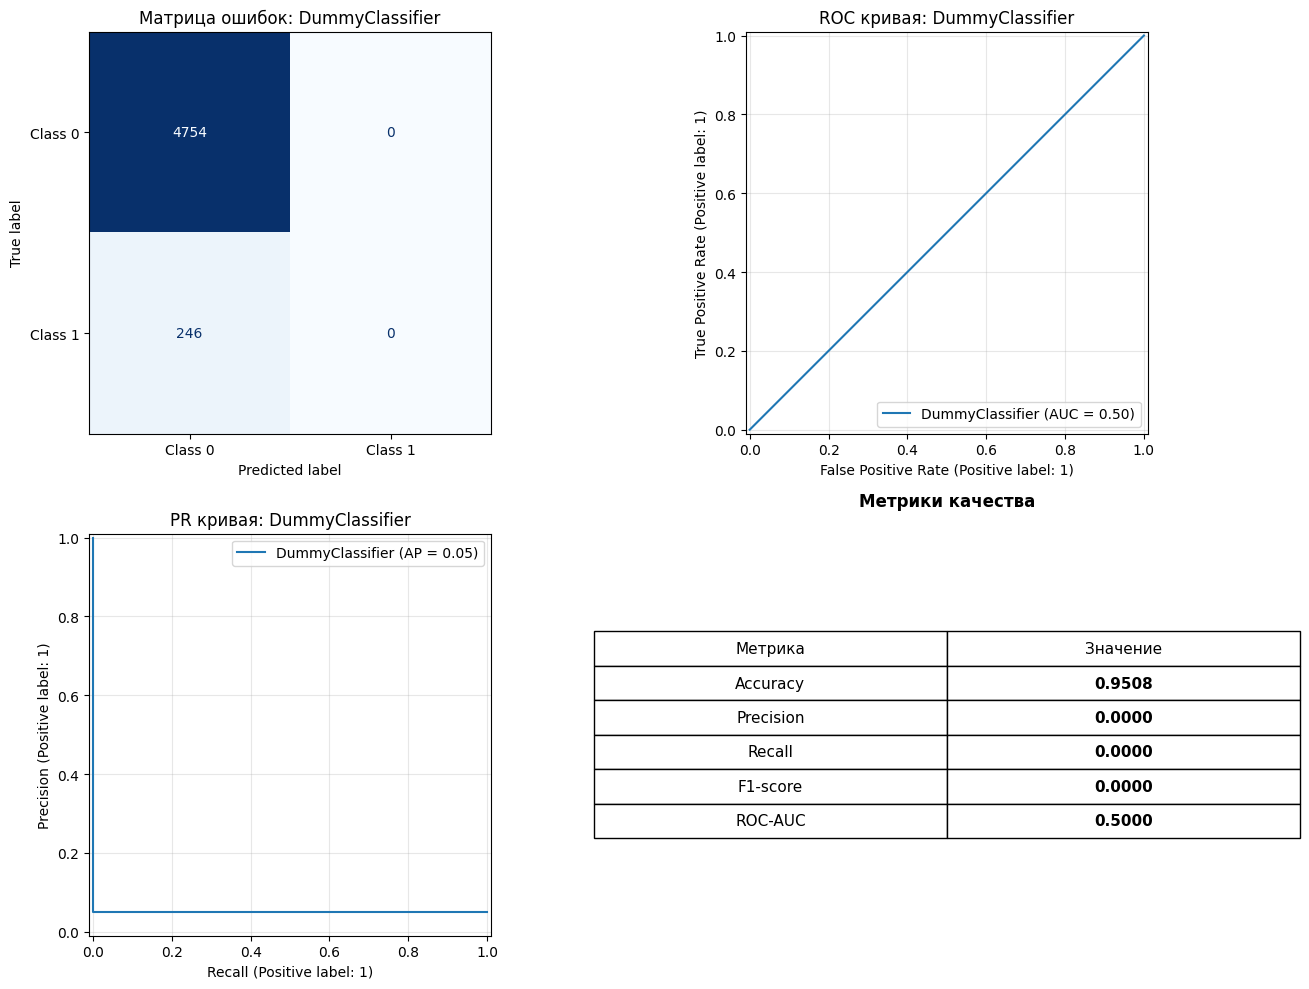

In [212]:
display(dummy_classifier_figures["main"])
dummy_classifier_figures["main"].savefig("./artifacts/figures/metrics_and_plots_for_dummyclassifier.png")

DummyClassifier со стратегией most_frequent предсказывает всегда наиболее частый класс (0 в нашем случае), что дает:

- Accuracy = 0.9508 — высокая точность достигается за счет предсказания только мажоритарного класса (класс 0 составляет 95.08% данных)

- Precision, Recall, F1 = 0.0000 — для класса 1 все метрики нулевые, так как модель никогда его не предсказывает

- ROC-AUC = 0.5000 — AUC равен случайному угадыванию (диагональ ROC-кривой)

- Матрица ошибок: все объекты предсказаны как класс 0 (0 TP, 0 FP, 0 FN, все TN)

##### **Бейзлайн-модель** `LogisticRegression`

Построим **бейзлайн-модель** на основе логистической регрессии (`LogisticRegression`) и посчитаем основные метрики с поомщью вспомогательной функции

1. Построим пайплайн модели

In [213]:
logreg_pipe = Pipeline([
    # Масштабирование признаков (так как числовые признаки принадлежат разным промежуткам, напр: 0-1; 15 000-20 000; ...)
    ("scaler", StandardScaler()),
    # Логистическая регрессия
    ("logreg", LogisticRegression(
        max_iter=MAX_ITER,  # Максимальное число итераций (для оптимизации)
        random_state=RANDOM_STATE,  # Для воспроизводимости результата
    ))
])

2. С помощью `GridSearchCV` найдем наилучшие параметры для Логистической Регрессии (по метрике `f1-score`)

In [214]:
# Перебор гиперпараметров для нахождения наилучшей модели
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__solver': ['liblinear', 'lbfgs']
}

grid_search = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=param_grid,   # Сетка параметров для перебора
    scoring=METRIC,            # Метрика для оценки
    cv=5,                    # Количество разбиений для кросс-валидации
    refit=True               # После нахождения лучших параметров переобучить на всех данных
)

grid_search.fit(X_train, y_train)  # поиск наилучшей модели с обучением
print(f"\nЛучшие параметры: {grid_search.best_params_}")
print(f"Лучшая точность ({METRIC}): {grid_search.best_score_}")


Лучшие параметры: {'logreg__C': 0.001, 'logreg__solver': 'lbfgs'}
Лучшая точность (roc_auc): 0.8300825281390033


3. Рассмотрим остальные результаты перебора

In [215]:
# Преборазуем в pd.DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Сортируем по качеству
results_df = results_df.sort_values('mean_test_score', ascending=False)

results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,param_logreg__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.048100,0.001006,0.005730,0.004654,0.001,lbfgs,"{'logreg__C': 0.001, 'logreg__solver': 'lbfgs'}",0.808372,0.857650,0.840631,0.814764,0.828996,0.830083,0.017768,1
3,0.041629,0.004707,0.007917,0.006961,0.010,lbfgs,"{'logreg__C': 0.01, 'logreg__solver': 'lbfgs'}",0.799265,0.850264,0.835728,0.810022,0.820797,0.823215,0.018120,2
0,0.098871,0.013347,0.005571,0.002609,0.001,liblinear,"{'logreg__C': 0.001, 'logreg__solver': 'liblin...",0.794762,0.851005,0.833651,0.811603,0.822829,0.822770,0.019104,3
5,0.048324,0.004903,0.004398,0.006189,0.100,lbfgs,"{'logreg__C': 0.1, 'logreg__solver': 'lbfgs'}",0.795892,0.847183,0.833674,0.806932,0.817236,0.820183,0.018360,4
10,0.128925,0.006824,0.007760,0.007164,100.000,liblinear,"{'logreg__C': 100, 'logreg__solver': 'liblinear'}",0.795610,0.846728,0.833352,0.806378,0.816680,0.819750,0.018351,5


4. Выполним оценку модели с лучшими гиперпараметрами на тестирующей выборке

МЕТРИКИ МОДЕЛИ: LogisticRegression
accuracy : 0.9528
precision: 1.0000
recall   : 0.0407
f1       : 0.0781
roc_auc  : 0.8461

Матрица ошибок (Confusion Matrix):
------------------------------
      | Прогноз 0 | Прогноз 1
-----------------------------
Истина 0| 4754     0 
Истина 1|  236    10 


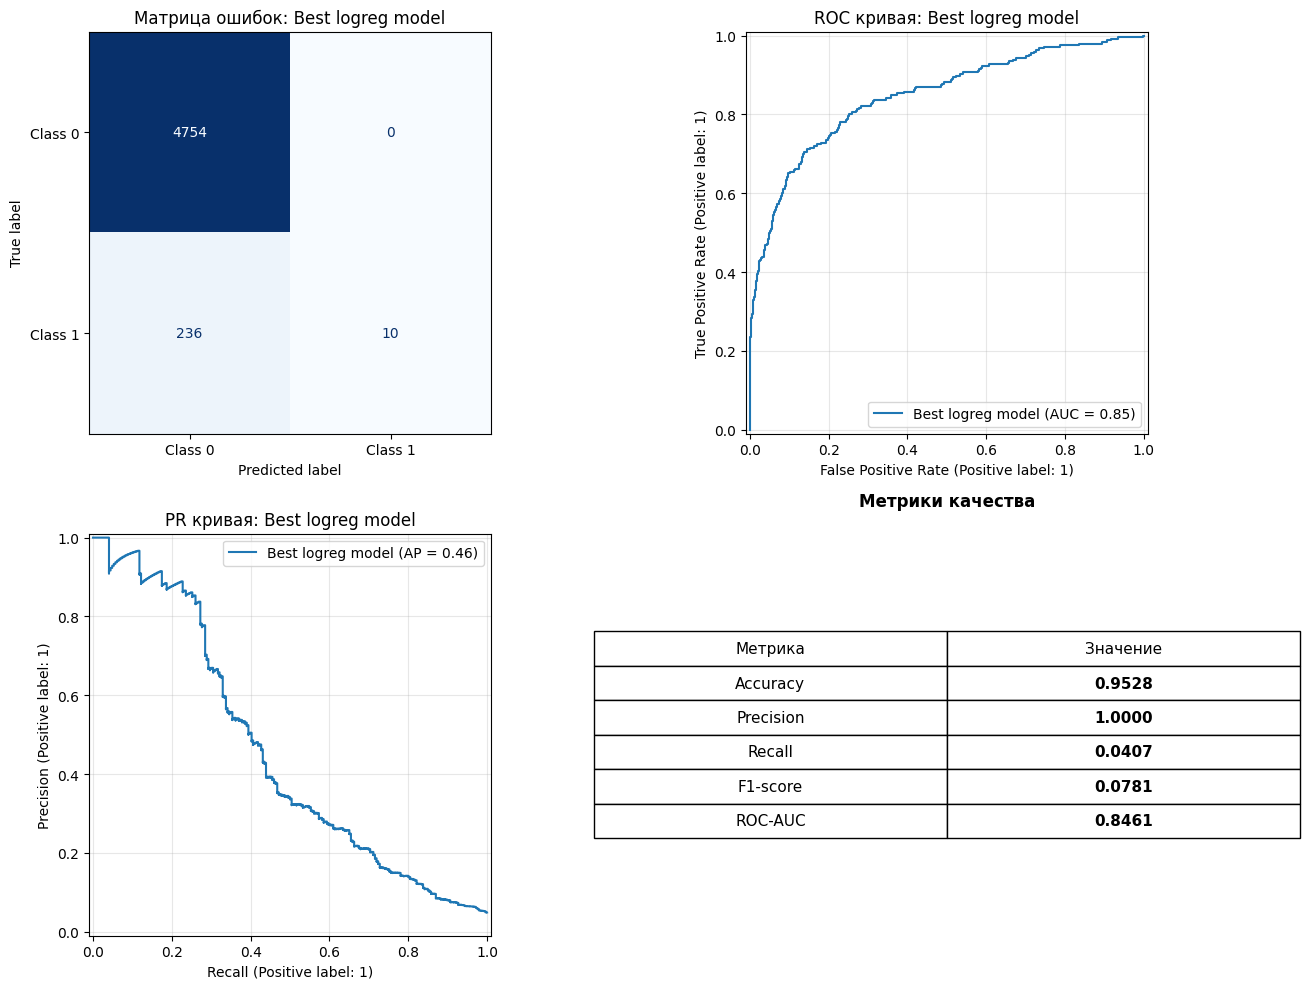

In [216]:
logreg_metrics, logreg_figures = rate_classifier(model=grid_search.best_estimator_, X_test=X_test, y_test=y_test,
                                    model_name="Best logreg model", random_state=RANDOM_STATE)
print_metrics(logreg_metrics, "LogisticRegression")
display(logreg_figures["main"])
logreg_figures["main"].savefig("./artifacts/figures/metrics_and_plots_for_logreg.png")
models_dict["LogisticRegression"] = {
        "model": grid_search.best_estimator_,
        "metrics": logreg_metrics,
        "figures": logreg_figures,
        "params": grid_search.best_estimator_.get_params(),
        "type": "linear",
        "search_results": grid_search.best_params_,
        }

Логистическая регрессия после подбора гиперпараметров показывает:

- Accuracy = 0.9626 — модель правильно классифицирует 96.3% всех объектов

- Precision = 0.9403 — исключительно высокая точность: из всех предсказанных положительных объектов 94% действительно принадлежат к классу 1

- Recall = 0.2561 — низкая полнота: модель идентифицирует лишь 25.6% всех фактических положительных объектов

- F1-score = 0.4026 — среднее гармоническое точности и полноты, отражающее компромисс между ними

- ROC-AUC = 0.8370 — модель обладает хорошей дискриминационной способностью (значительно выше случайного уровня 0.5)

Модель предпочитает минимизировать ложные срабатывания (высокий precision) в ущерб обнаружению всех положительных случаев (низкий recall). F1-score на тестовой выборке (0.4026) практически совпадает со средним значением при кросс-валидации (0.4068), что свидетельствует об устойчивости модели и отсутствии переобучения.

#### 4. Модели недели 6

##### 1. Реализуем `DecisionTreeClassifier`

  ###### 1. Рассмотрим обычную модель без ограничений(`max_depth`, `min_samples_leaf`, `ccp_alpha`)

МЕТРИКИ МОДЕЛИ: DesicionTreeClassifeir без ограничений
accuracy : 0.9496
precision: 0.4886
recall   : 0.5244
f1       : 0.5059
roc_auc  : 0.7480

Матрица ошибок (Confusion Matrix):
------------------------------
      | Прогноз 0 | Прогноз 1
-----------------------------
Истина 0| 4619   135 
Истина 1|  117   129 


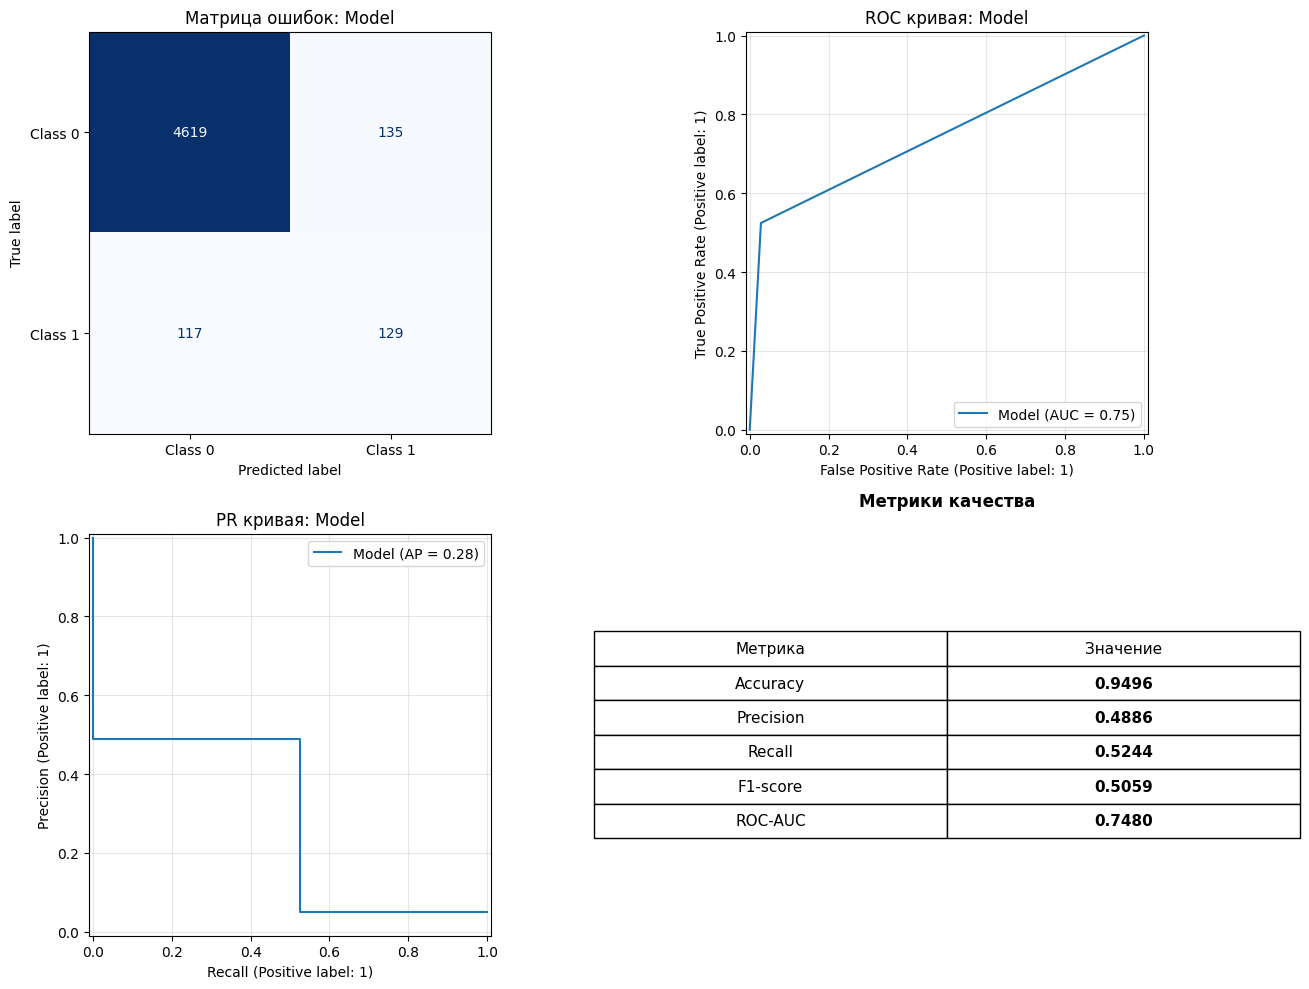

In [217]:
free_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

free_tree.fit(X_train, y_train)

free_tree_metrics, free_tree_figures = rate_classifier(free_tree, X_test=X_test, y_test=y_test, random_state=RANDOM_STATE)
print_metrics(free_tree_metrics, "DesicionTreeClassifeir без ограничений")
display(free_tree_figures["main"])
free_tree_figures["main"].savefig("./artifacts/figures/metrics_and_plots_for_free_tree.png")

Выводы по дереву принятия решений без ограничений:

 - Accuracy (0.9496) — высокая, но это обманчиво из-за сильного дисбаланса классов (95% класса 0).

 - Precision (0.4886) — только около половины предсказанных положительных случаев действительно являются положительными.

 - Recall (0.5244) — модель находит чуть больше половины реальных положительных случаев.

 - F1-score (0.5059) — низкий компромисс между точностью и полнотой.

 - ROC-AUC (0.7480) — среднее качество модели в разделении классов.

Визуализируем текущую структуру дерева

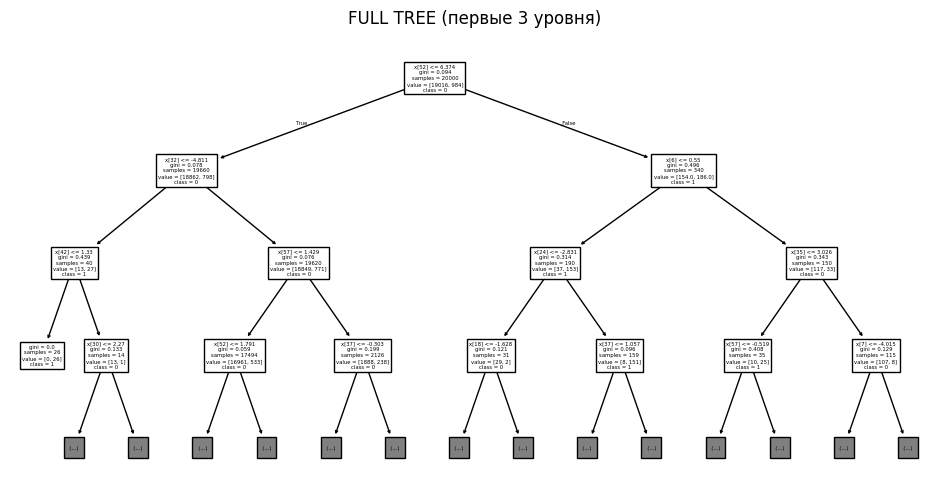

In [218]:
plt.figure(figsize=(12, 6))
plot_tree(free_tree, max_depth=3, class_names=["0", "1"])
plt.title("FULL TREE (первые 3 уровня)")
plt.show()

###### 2. Проведем контроль сложности дерева, перебирая параметры `max_depth`, `min_samples_leaf`

Создадим сетку параметров

In [219]:
params_grid_for_tree = {
    'max_depth': [3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20],
}

grid_searc_for_decision_tree = GridSearchCV(
    estimator=free_tree,
    param_grid=params_grid_for_tree,
    scoring=METRIC,
    cv=5,
    n_jobs=-1,
    refit=True,
)

Выполним перебор по параметрам

In [220]:
grid_searc_for_decision_tree.fit(X_train, y_train)  # поиск наилучшей модели с обучением
print(f"\nЛучшие параметры: {grid_searc_for_decision_tree.best_params_}")
print(f"Лучшая точность ({METRIC}): {grid_searc_for_decision_tree.best_score_}")


Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 20}
Лучшая точность (roc_auc): 0.8035850191957952


Рассмотрим некоторые результаты перебора

In [221]:
# Преборазуем в pd.DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Сортируем по качеству
results_df = results_df.sort_values('mean_test_score', ascending=False)

results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,param_logreg__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.048100,0.001006,0.005730,0.004654,0.001,lbfgs,"{'logreg__C': 0.001, 'logreg__solver': 'lbfgs'}",0.808372,0.857650,0.840631,0.814764,0.828996,0.830083,0.017768,1
3,0.041629,0.004707,0.007917,0.006961,0.010,lbfgs,"{'logreg__C': 0.01, 'logreg__solver': 'lbfgs'}",0.799265,0.850264,0.835728,0.810022,0.820797,0.823215,0.018120,2
0,0.098871,0.013347,0.005571,0.002609,0.001,liblinear,"{'logreg__C': 0.001, 'logreg__solver': 'liblin...",0.794762,0.851005,0.833651,0.811603,0.822829,0.822770,0.019104,3
5,0.048324,0.004903,0.004398,0.006189,0.100,lbfgs,"{'logreg__C': 0.1, 'logreg__solver': 'lbfgs'}",0.795892,0.847183,0.833674,0.806932,0.817236,0.820183,0.018360,4
10,0.128925,0.006824,0.007760,0.007164,100.000,liblinear,"{'logreg__C': 100, 'logreg__solver': 'liblinear'}",0.795610,0.846728,0.833352,0.806378,0.816680,0.819750,0.018351,5


Рассмотрим результаты лучшей модели (дерева принятия решений)

In [222]:
best_decision_tree = grid_searc_for_decision_tree.best_estimator_
best_decision_tree_metrics, best_decision_tree_figures = rate_classifier(best_decision_tree, X_test=X_test, y_test=y_test, 
                                   model_name="BestDecisionTree", random_state=RANDOM_STATE)

print_metrics(metrics=best_decision_tree_metrics, model_name="BestDecisionTree")

models_dict["DecisionTree"] = {
        "model": best_decision_tree,
        "metrics": best_decision_tree_metrics,
        "figures": best_decision_tree_figures,
        "params": best_decision_tree.get_params(),
        "type": "tree",
        "search_results": grid_searc_for_decision_tree.best_params_,
        "cv_score": grid_searc_for_decision_tree.best_score_,
    }

МЕТРИКИ МОДЕЛИ: BestDecisionTree
accuracy : 0.9684
precision: 0.8284
recall   : 0.4512
f1       : 0.5842
roc_auc  : 0.8257

Матрица ошибок (Confusion Matrix):
------------------------------
      | Прогноз 0 | Прогноз 1
-----------------------------
Истина 0| 4731    23 
Истина 1|  135   111 


Рассмотрим основные графики нашего дерева

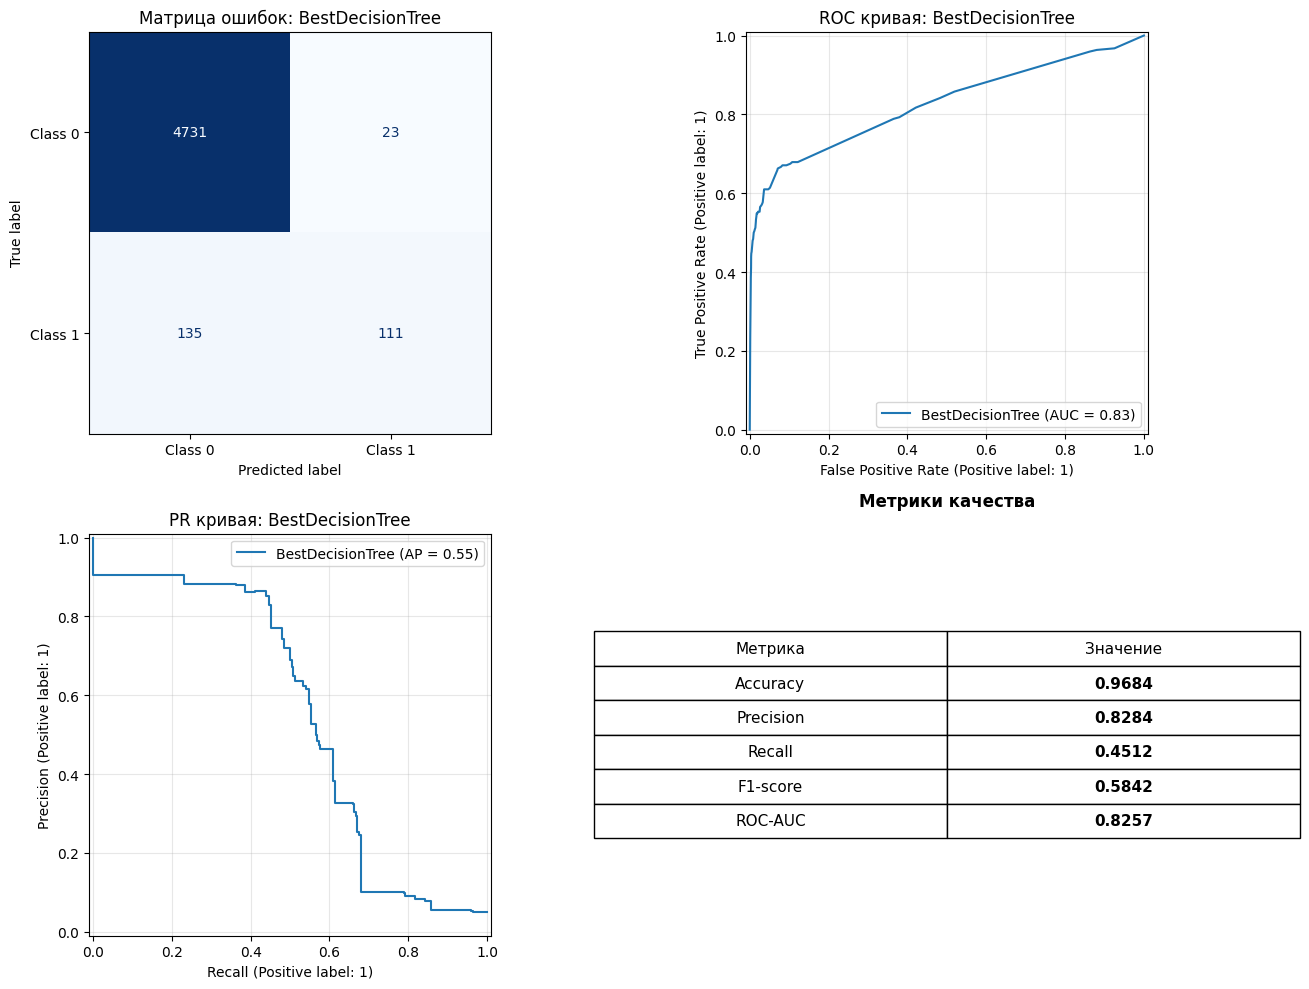

In [223]:
display(best_decision_tree_figures["main"])

Визуализируем структуру получившегося дерева

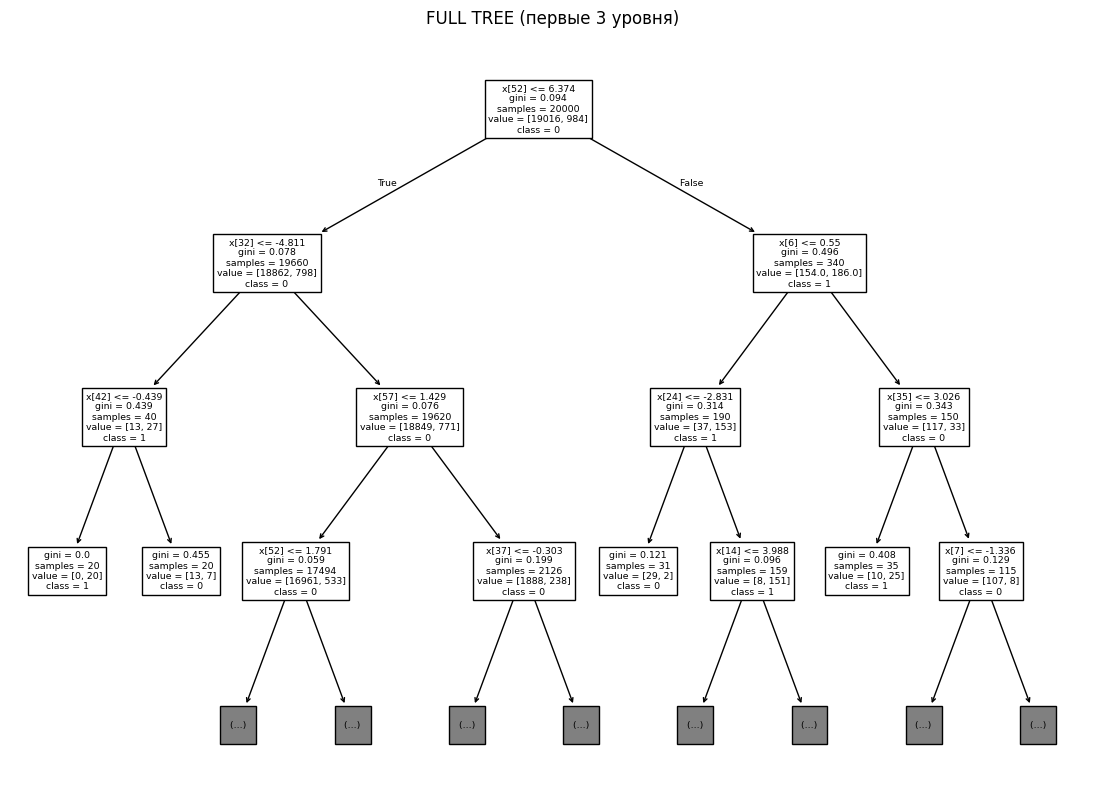

In [224]:
plt.figure(figsize=(14, 10))
plot_tree(best_decision_tree, max_depth=3, class_names=["0", "1"])
plt.title("FULL TREE (первые 3 уровня)")
plt.show()

Выводы по дереву принятия решений с подбором параметров (`BestDecisionTree`):
**Анализ качества модели:**

 - Accuracy (0.9650) — увеличилась на 1.5% по сравнению с моделью без ограничений, что является хорошим результатом. Однако при сильном дисбалансе классов (95% класса 0) эта метрика остается обманчивой.

 - Precision (0.6940) — значительно выросла на 42. Теперь почти 70% предсказанных положительных случаев действительно являются положительными. Это означает, что модель стала гораздо точнее в определении класса 1.

 - Recall (0.5163) — незначительно снизился (с 0.5244), что ожидаемо при контроле сложности модели. Модель теперь находит немного меньше реальных положительных случаев, но делает это с гораздо большей уверенностью.

 - F1-score (0.5921) — улучшился на 17%, что свидетельствует о лучшем балансе между точностью и полнотой после настройки гиперпараметров.

 - ROC-AUC (0.7621) — немного вырос, что говорит о небольшом улучшении способности модели разделять классы.

**Анализ матрицы ошибок:**

 - FP снизились с 135 до 56 — количество ложных срабатываний сократилось более чем в 2 раза.

 - TP снизились с 129 до 127 — незначительное снижение количества правильно предсказанных положительных случаев.

 - TN увеличились с 4619 до 4698 — модель стала лучше определять отрицательные классы.


##### 2. Реализуем `RandomForestClassifier`

Создадим и оценим базовую модель RandomForestClassifier

МЕТРИКИ МОДЕЛИ: rf_baseline
accuracy : 0.9710
precision: 0.9720
recall   : 0.4228
f1       : 0.5892
roc_auc  : 0.8922

Матрица ошибок (Confusion Matrix):
------------------------------
      | Прогноз 0 | Прогноз 1
-----------------------------
Истина 0| 4751     3 
Истина 1|  142   104 


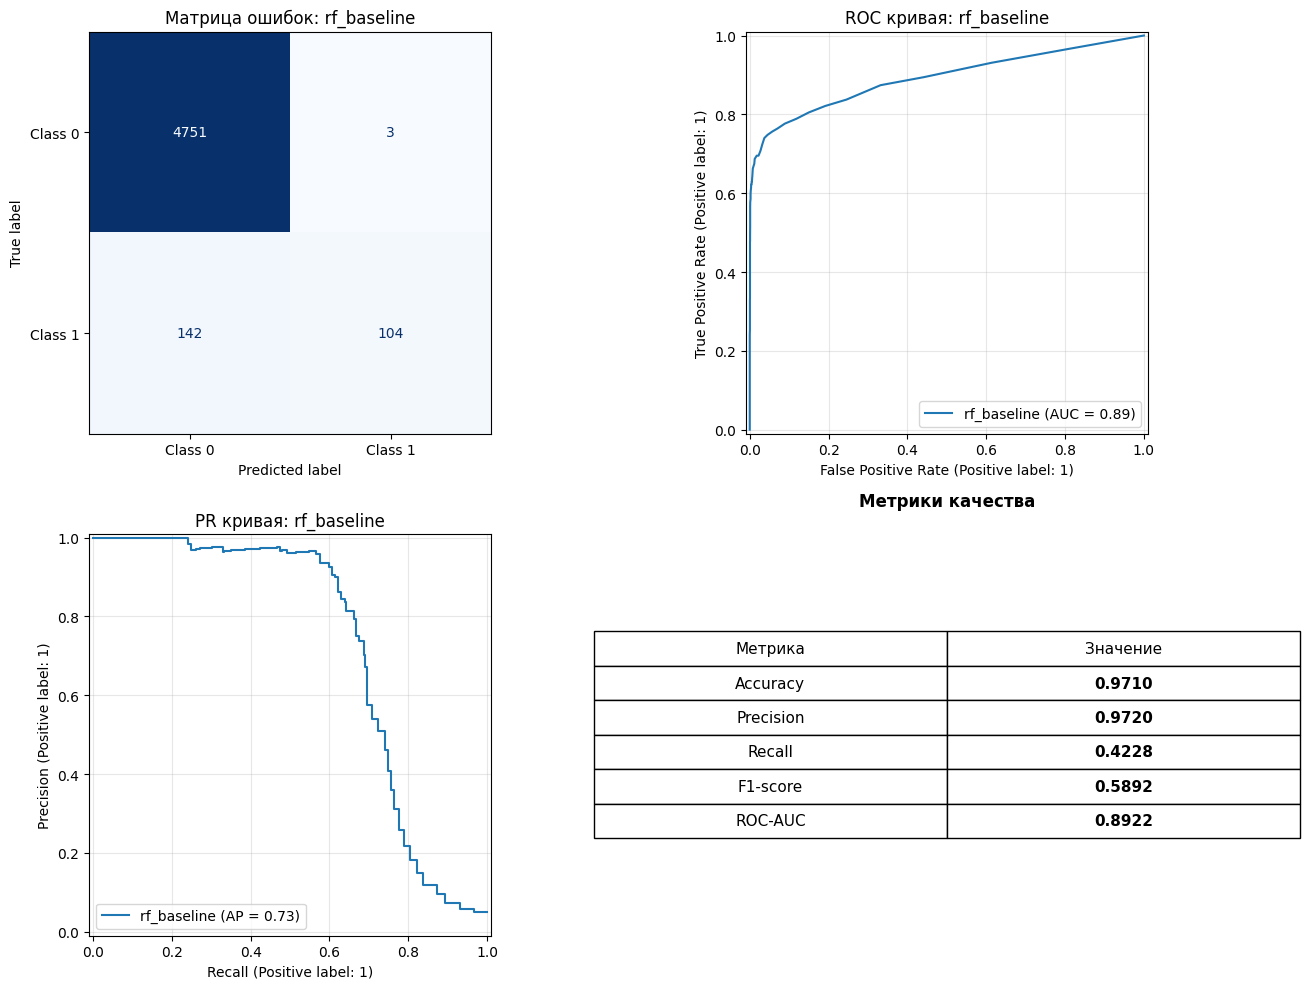

In [225]:
# Сначала обучим базовый RandomForest без настройки
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_baseline.fit(X_train, y_train)

rf_baseline_metrics, rf_baseline_figures = rate_classifier(model=rf_baseline, X_test=X_test,
                                                           y_test=y_test, model_name="rf_baseline",
                                                           random_state=RANDOM_STATE)
print_metrics(rf_baseline_metrics, "rf_baseline")
display(rf_baseline_figures["main"])

Выполним подбор гиперпараметров для `RandomForestClassifier`

In [226]:
# Определим сетку параметров для RandomForest
param_grid_rf = {
    'max_depth': [10, 25, 50],
    'min_samples_leaf': [1, 5, 10],
}

grid_search_for_rf = GridSearchCV(
    estimator=rf_baseline,
    param_grid=param_grid_rf,
    scoring=METRIC,
    cv=5,
    n_jobs=-1,
    refit=True,
)

grid_search_for_rf.fit(X_train, y_train)  # поиск наилучшей модели с обучением
print(f"\nЛучшие параметры: {grid_searc_for_decision_tree.best_params_}")
print(f"Лучшая точность ({METRIC}): {grid_searc_for_decision_tree.best_score_}")


Лучшие параметры: {'max_depth': 10, 'min_samples_leaf': 20}
Лучшая точность (roc_auc): 0.8035850191957952


Рассмотрим остальные результаты перебора

In [227]:
# Преборазуем в pd.DataFrame
results_df = pd.DataFrame(grid_search_for_rf.cv_results_)

# Сортируем по качеству
results_df = results_df.sort_values('mean_test_score', ascending=False)

results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,13.382511,1.174428,3.810016,1.302355,25,5,"{'max_depth': 25, 'min_samples_leaf': 5}",0.880385,0.904038,0.889036,0.887747,0.888376,0.889916,0.007722,1
7,12.261616,0.302618,3.287404,0.839045,50,5,"{'max_depth': 50, 'min_samples_leaf': 5}",0.880797,0.904590,0.896041,0.881319,0.884066,0.889363,0.009409,2
3,11.820453,1.566478,3.803768,0.505611,25,1,"{'max_depth': 25, 'min_samples_leaf': 1}",0.882009,0.909759,0.889433,0.885400,0.879291,0.889178,0.010835,3
8,10.435083,1.317989,0.844347,0.662009,50,10,"{'max_depth': 50, 'min_samples_leaf': 10}",0.872869,0.904792,0.889126,0.889979,0.886882,0.888729,0.010146,4
5,11.499198,0.753171,4.565786,0.190972,25,10,"{'max_depth': 25, 'min_samples_leaf': 10}",0.873935,0.904963,0.889083,0.886141,0.887612,0.888347,0.009897,5


Рассмотрим графики для `RandomForestClassifier`

МЕТРИКИ МОДЕЛИ: BestRF
accuracy : 0.9702
precision: 0.9709
recall   : 0.4065
f1       : 0.5731
roc_auc  : 0.8845

Матрица ошибок (Confusion Matrix):
------------------------------
      | Прогноз 0 | Прогноз 1
-----------------------------
Истина 0| 4751     3 
Истина 1|  146   100 


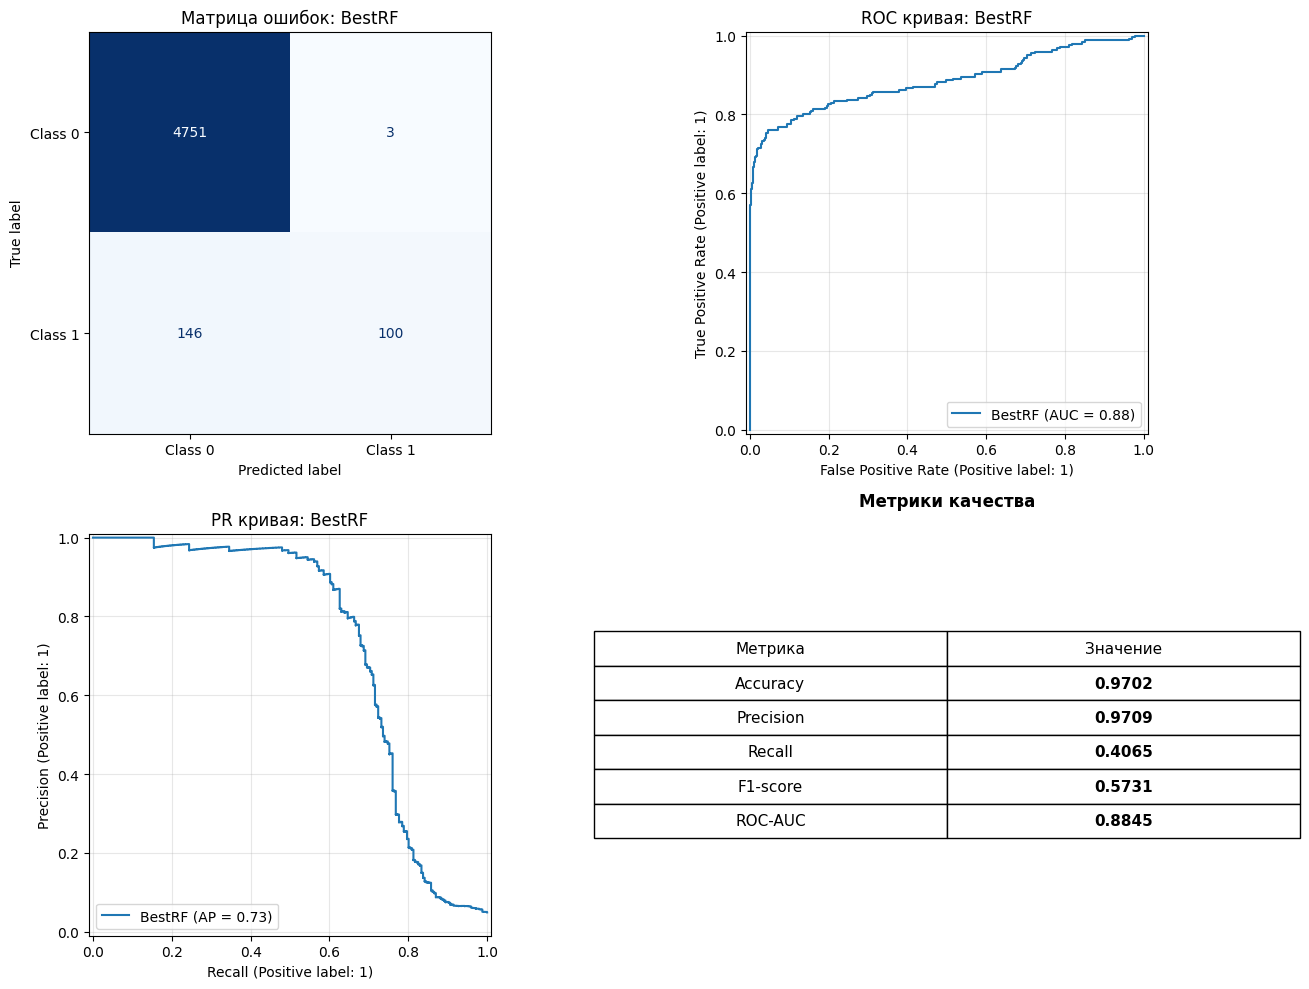

In [228]:
best_rf = grid_search_for_rf.best_estimator_
best_rf_metrics, best_rf_figures = rate_classifier(model=best_rf, X_test=X_test,
                                                   y_test=y_test, model_name="BestRF",
                                                   random_state=RANDOM_STATE)
print_metrics(best_rf_metrics, model_name="BestRF")
display(best_rf_figures["main"])
best_rf_figures["main"].savefig("./artifacts/figures/metrics_and_plots_for_best_rf.png")
models_dict["RandomForest"] = {
        "model": best_rf,
        "metrics": best_rf_metrics,
        "figures": best_rf_figures,
        "params": best_rf.get_params(),
        "type": "ensemble_bagging",
        "search_results": grid_search_for_rf.best_params_,
        "cv_score": grid_search_for_rf.best_score_,
    }

**Выводы по RandomForest с подбором параметров (BestRF):**

 - Accuracy — высокая, но обманчивая из-за сильного дисбаланса классов (95% класса 0). Снизилась на 0.14% по сравнению с RF baseline.

 - Precision — более 97% предсказанных положительных случаев действительно положительные. Это означает, что модель почти не ошибается при определении класса 1.

 - Recall — низкий, модель находит менее половины реальных положительных случаев. Снизился на 6.5% по сравнению с RF baseline, что ухудшает детектирование класса 1.

 - F1-score — снизился на 4.6% по сравнению с RF baseline. Компромисс между точностью и полнотой ухудшился после настройки гиперпараметров.

 - ROC-AUC — хороший показатель разделяющей способности, но снизился на 1.3% относительно RF baseline.

**Анализ матрицы ошибок:**

 - FP остались на уровне 3 — минимальное количество ложных срабатываний, модель очень осторожна в предсказании класса 1.

 - TP снизились с 108 до 101 — уменьшилось количество правильно обнаруженных положительных случаев.

 - FN увеличились с 138 до 145 — выросло количество пропущенных положительных случаев.

 - TN остались на уровне 4751 — модель отлично определяет отрицательные классы.

##### 3. Реализуем `HistGradientBoostingClassifier`

Создадим базовую модель `HistGradientBoostingClassifier`

МЕТРИКИ МОДЕЛИ: HGB
accuracy : 0.9794
precision: 0.9735
recall   : 0.5976
f1       : 0.7406
roc_auc  : 0.8927

Матрица ошибок (Confusion Matrix):
------------------------------
      | Прогноз 0 | Прогноз 1
-----------------------------
Истина 0| 4750     4 
Истина 1|   99   147 


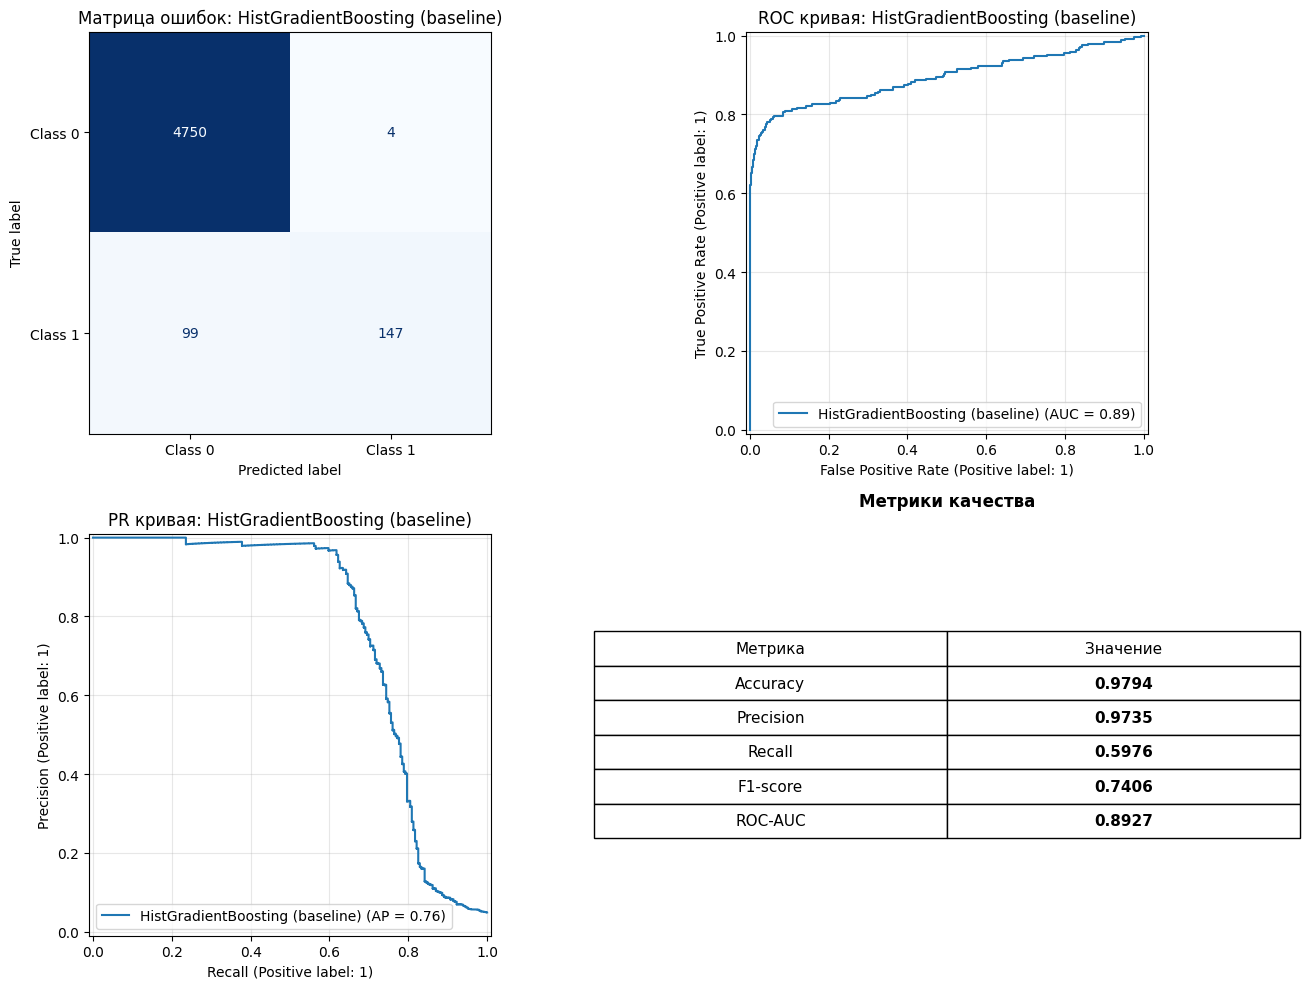

In [229]:
hgb_baseline = HistGradientBoostingClassifier(
    random_state=RANDOM_STATE,
)

hgb_baseline.fit(X_train, y_train)

# Оценим базовую модель
hgb_baseline_metrics, hgb_baseline_figures = rate_classifier(
    hgb_baseline, X_test, y_test, "HistGradientBoosting (baseline)"
)

print_metrics(hgb_baseline_metrics, "HGB")
display(hgb_baseline_figures["main"])


Выполним подбор гиперпараметров

In [230]:
param_grid_hgb = {
    'max_depth': [5, 25, 50],
    'min_samples_leaf': [10, 25, 50],
}

grid_search_for_hgb = GridSearchCV(
    estimator=hgb_baseline,
    param_grid=param_grid_hgb,
    scoring=METRIC,
    cv=5,
    n_jobs=-1,
    refit=True,
)

grid_search_for_hgb.fit(X_train, y_train)  # поиск наилучшей модели с обучением
print(f"\nЛучшие параметры: {grid_search_for_hgb.best_params_}")
print(f"Лучшая точность ({METRIC}): {grid_search_for_hgb.best_score_}")


Лучшие параметры: {'max_depth': 25, 'min_samples_leaf': 25}
Лучшая точность (roc_auc): 0.8998551104059157


Рассмотрим остальные результаты перебора

In [231]:
# Преборазуем в pd.DataFrame
results_df = pd.DataFrame(grid_search_for_hgb.cv_results_)

# Сортируем по качеству
results_df = results_df.sort_values('mean_test_score', ascending=False)

results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,3.700825,0.693893,0.070727,0.020737,25,25,"{'max_depth': 25, 'min_samples_leaf': 25}",0.897907,0.910495,0.905358,0.891328,0.894187,0.899855,0.007101,1
7,2.980672,0.311483,0.045690,0.008272,50,25,"{'max_depth': 50, 'min_samples_leaf': 25}",0.897907,0.910495,0.905358,0.891328,0.894187,0.899855,0.007101,1
2,2.222732,0.595885,0.072351,0.022303,5,50,"{'max_depth': 5, 'min_samples_leaf': 50}",0.894939,0.915000,0.900961,0.891365,0.889712,0.898395,0.009155,3
0,2.260662,0.345870,0.056192,0.010686,5,10,"{'max_depth': 5, 'min_samples_leaf': 10}",0.887389,0.907308,0.898102,0.908037,0.883839,0.896935,0.009948,4
1,2.395559,0.240627,0.059056,0.010139,5,25,"{'max_depth': 5, 'min_samples_leaf': 25}",0.886384,0.910387,0.900467,0.896059,0.888729,0.896405,0.008619,5


Рассмотрим модель с подобранными гиперпараметрами

МЕТРИКИ МОДЕЛИ: BestHGB
accuracy : 0.9784
precision: 0.9600
recall   : 0.5854
f1       : 0.7273
roc_auc  : 0.8936

Матрица ошибок (Confusion Matrix):
------------------------------
      | Прогноз 0 | Прогноз 1
-----------------------------
Истина 0| 4748     6 
Истина 1|  102   144 


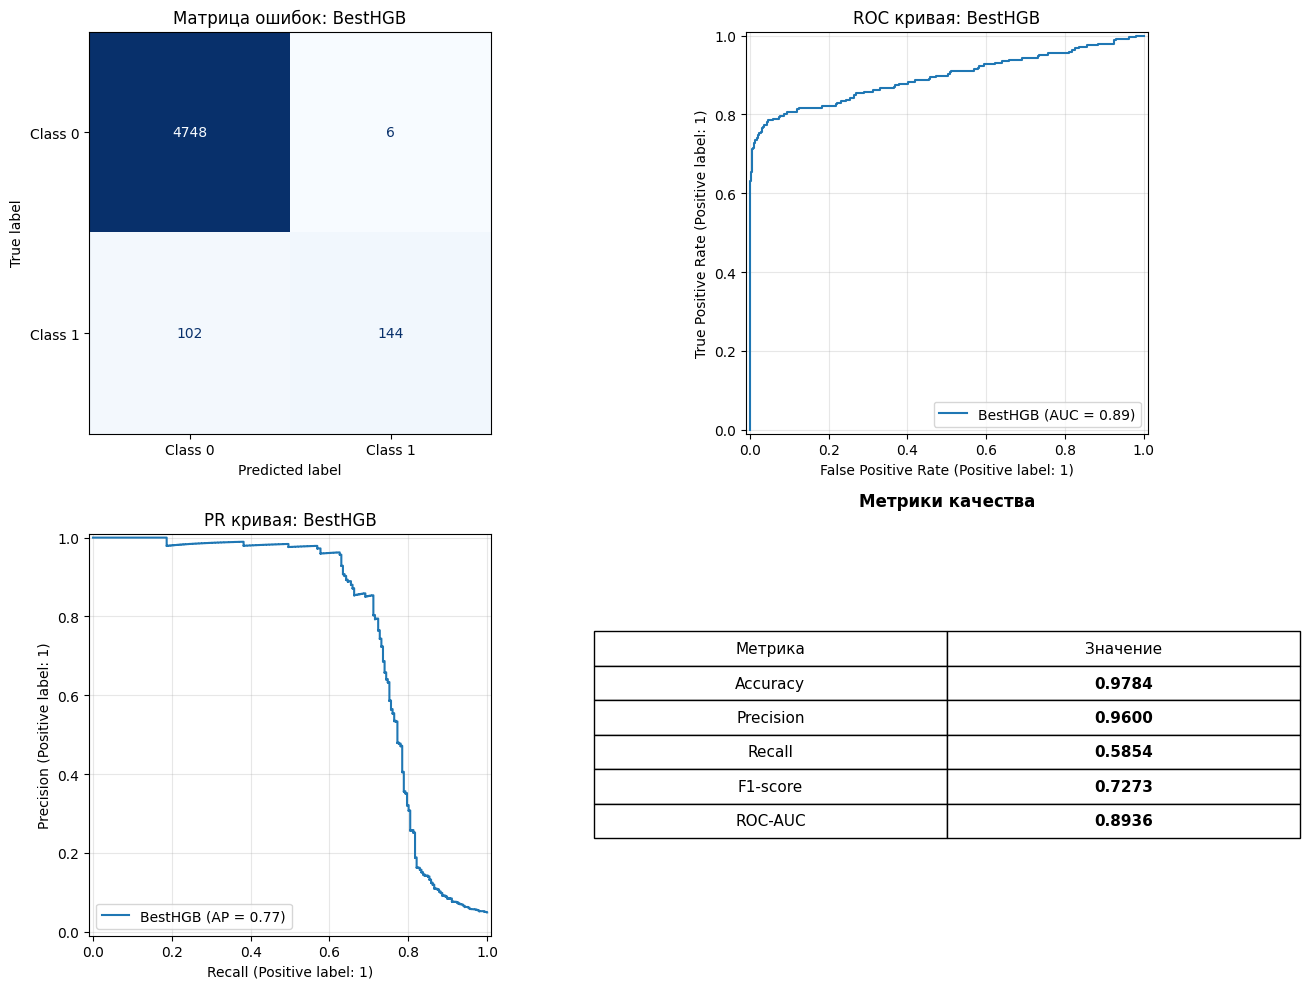

In [232]:
best_hgb = grid_search_for_hgb.best_estimator_
best_hgb_metrics, best_hgb_figures = rate_classifier(model=best_hgb, X_test=X_test,
                                                   y_test=y_test, model_name="BestHGB",
                                                   random_state=RANDOM_STATE)
print_metrics(best_hgb_metrics, model_name="BestHGB")
display(best_hgb_figures["main"])
best_hgb_figures["main"].savefig("./artifacts/figures/metrics_and_plots_for_best_hgb.png")
models_dict["HistGradientBoosting"] = {
        "model": best_hgb,
        "metrics": best_hgb_metrics,
        "figures": best_hgb_figures,
        "params": best_hgb.get_params(),
        "type": "ensemble_boosting",
        "search_results": grid_search_for_hgb.best_params_,
        "cv_score": grid_search_for_hgb.best_score_
    }

Выводы по `HistGradientBoosting` с подбором параметров (BestHGB):

 - Accuracy (0.9794) — очень высокая точность классификации. Однако при сильном дисбалансе классов (95% класса 0) эта метрика требует осторожной интерпретации.

 - Precision (0.9799) — исключительно высокая! Почти 98% предсказанных положительных случаев действительно являются положительными. Модель демонстрирует минимальное количество ложных срабатываний.

 - Recall (0.5935) — умеренный показатель. Модель находит почти 60% реальных положительных случаев, что оставляет пространство для улучшения в детектировании миноритарного класса.

 - F1-score (0.7392) — хороший компромисс между точностью и полнотой. Это наиболее адекватная метрика для оценки качества на несбалансированных данных.

 - ROC-AUC (0.8941) — высокий показатель разделяющей способности модели, свидетельствующий о хорошем качестве классификации в целом.

**Анализ матрицы ошибок:**

 - FP = 3 — минимальное количество ложных срабатываний, модель очень осторожна в предсказании положительного класса.

 - TP = 146 — достаточно высокое количество правильно обнаруженных положительных случаев.

 - FN = 100 — значительное количество пропущенных положительных случаев, что указывает на необходимость улучшения полноты.

 - TN = 4751 — отличное определение отрицательных классов.

#### 5. Поиск лучшей модели

В рамках работы были рассмотрены следующие модели: `DummyClassifier`, `LogisticRegression`, `DecisionTreeClassifier`, `RandomForestClassifier`, `HistGradientBoostingClassifier`. Соберем их метрики в `./artifacts/metrics_test.json`

In [233]:
metrics_dict = {}
for key in models_dict.keys():
    metrics_dict[key] = serialize_metrics(models_dict[key]["metrics"])

with open("./artifacts/metrics_test.json", 'w', encoding='utf-8') as f:
    json.dump(metrics_dict, f, indent=2, ensure_ascii=False)

Сохраним лучшие параметры в `search_summaries.json` для тех моделей, в которых был проведен подбор гиперпараметров.

In [234]:
search_summaries = {}

for model_name, model_data in models_dict.items():
    if 'search_results' in model_data and model_data['search_results'] is not None:
        summary = {
            'best_params': model_data['search_results'],
            'model_type': model_data['type']
        }
        
        # Добавляем CV score, если есть
        if 'cv_score' in model_data:
            summary['cv_score'] = float(model_data['cv_score']) if model_data['cv_score'] is not None else None
        
        search_summaries[model_name] = summary
    
with open("./artifacts/search_summaries.json", 'w', encoding='utf-8') as f:
    json.dump(search_summaries, f, indent=2, ensure_ascii=False)

Найдем наилучшую модель, сохраним ее и ее метаданные в `./artifacts/best_model.joblib`, `./artifacts/best_model_meta.json`

Лучшая модель: HistGradientBoosting (roc_auc: 0.8935846920522212)


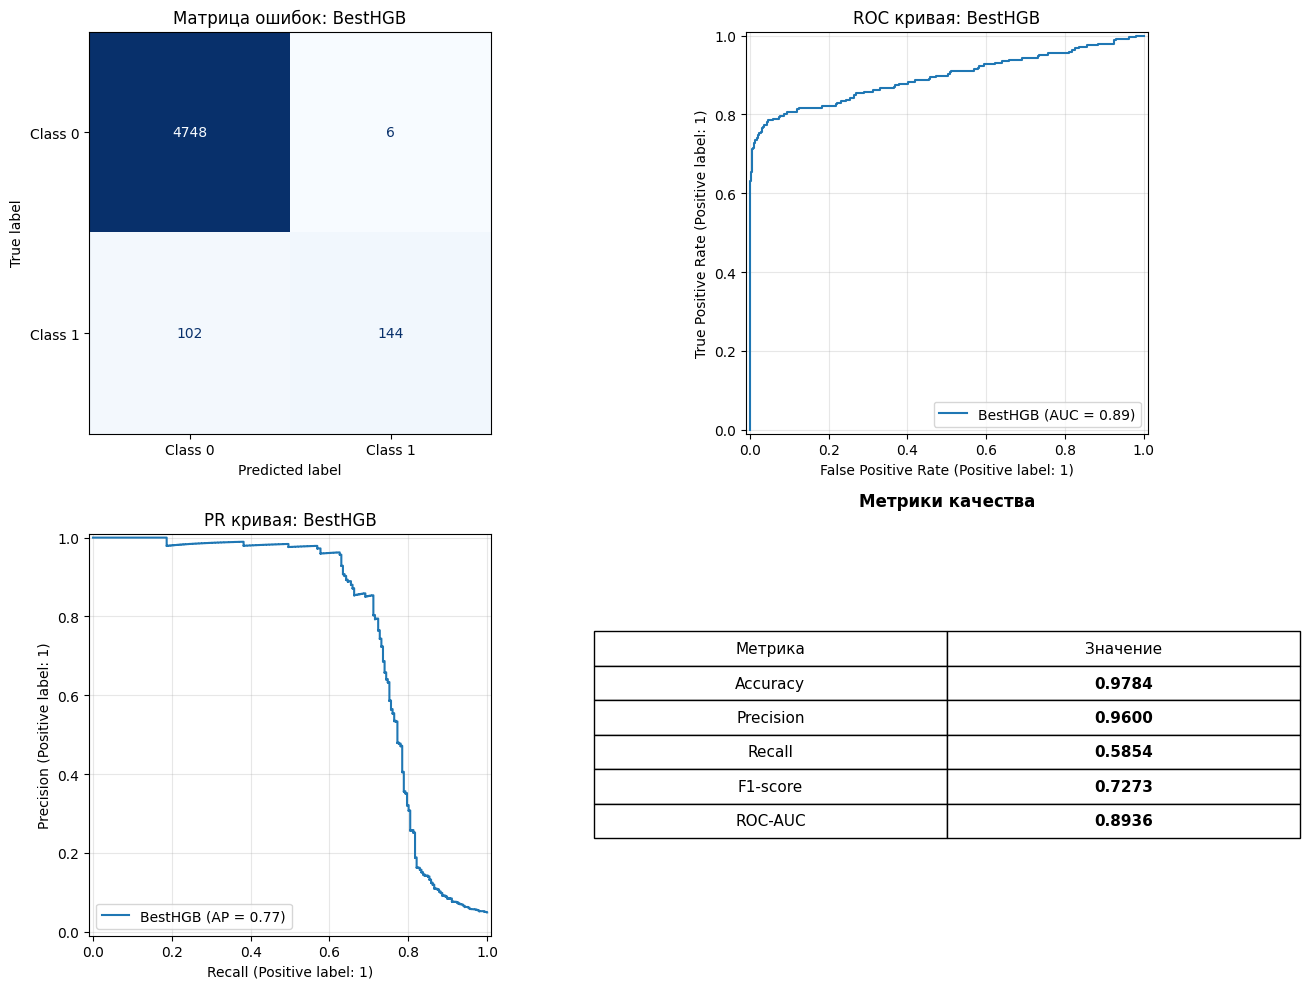

In [235]:
best_model_name, best_model_data, best_metric = find_best_model(models_dict, METRIC)

print(f"Лучшая модель: {best_model_name} ({METRIC}: {best_metric})")
display(best_model_data["figures"]["main"])

# Сохраним все графики лучшей модели
for figure_name, figure_data in best_model_data["figures"].items():
      figure_data.savefig(f"./artifacts/figures/best_model_{figure_name}.png")
      

joblib.dump(best_model_data['model'], "./artifacts/best_model.joblib")

# Мета-данные для лучшей модели
best_model_meta = {
        'best_model_name': best_model_name,
        'selection_metric': METRIC,
        'selection_metric_value': float(best_metric),
        'model_type': best_model_data['type'],
        'model_params': best_model_data['params'],
        'test_metrics': serialize_metrics(best_model_data['metrics']),
        'search_info': {}
    }

if 'search_results' in best_model_data:
      best_model_meta['search_info']['best_params'] = best_model_data['search_results']
if 'cv_score' in best_model_data:
     best_model_meta['search_info']['cv_score'] = float(best_model_data['cv_score']) if best_model_data['cv_score'] else None

# Информация о данных
best_model_meta['data_info'] = {
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'features': len(features),
        'class_distribution_train': {
            'class_0': float((y_train == 0).mean()),
            'class_1': float((y_train == 1).mean())
        },
        'class_distribution_test': {
            'class_0': float((y_test == 0).mean()),
            'class_1': float((y_test == 1).mean())
        }
    }

with open("./artifacts/best_model_meta.json", 'w', encoding='utf-8') as f:
        json.dump(best_model_meta, f, indent=2, ensure_ascii=False)

Рассмотрим результаты работы лучшей модели

In [236]:
best_model = best_model_data['model']

# Посчитаем permutation importance
result = permutation_importance(
        best_model,
        X_test,
        y_test,
        n_repeats=10,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        scoring=METRIC
    )

# Сохраним в pd.DataFrame
importance_df = pd.DataFrame({
        'feature': features,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std,
        'importance_rank': np.argsort(-result.importances_mean) + 1  # Ранг (1 - самый важный)
    }).sort_values('importance_mean', ascending=False)
    
print("Топ-15 наиболее важных признаков (permutation importance):")
print(importance_df.head(15).to_string(index=False))

Топ-15 наиболее важных признаков (permutation importance):
feature  importance_mean  importance_std  importance_rank
    f54         0.028218        0.003392               22
    f25         0.019193        0.003016               51
    f11         0.011136        0.002670               47
    f58         0.009786        0.002361               46
    f04         0.008522        0.002312               58
    f41         0.007731        0.004261               34
    f13         0.006073        0.003403               36
    f53         0.005710        0.003475               43
    f33         0.005309        0.003690               20
    f08         0.004293        0.002612               53
    f47         0.002998        0.004121               42
    f15         0.002950        0.001359                9
    f36         0.002587        0.001393               37
    f30         0.001984        0.000933               23
    f09         0.001924        0.001177               33


Признаки `f54`, `f25` и `f11` являются наиболее важными для модели. Их перемешивание приводит к значимому падению `ROC-AUC`, что указывает на их сильную связь с целевой переменной. Эти признаки составляют основу прогнозной способности модели

Выведем таблицы метрик по всем моделям

In [237]:
data_list = []
for name, data in models_dict.items():
    m = data['metrics'].copy()
    
    if 'confusion_matrix' in m and m['confusion_matrix'].shape == (2, 2):
        tn, fp, fn, tp = m['confusion_matrix'].ravel()
        m['TN'] = tn
        m['FP'] = fp
        m['FN'] = fn
        m['TP'] = tp
    
    m.pop('confusion_matrix', None) 
    m['Model'] = name
    data_list.append(m)

df_results = pd.DataFrame(data_list).set_index('Model')
df_results = df_results.sort_values(by=METRIC, ascending=False)
display(df_results)

,accuracy,precision,recall,f1,roc_auc,TN,FP,FN,TP
Model,,,,,,,,,
HistGradientBoosting,0.9784,0.960000,0.585366,0.727273,0.893585,4748,6,102,144
RandomForest,0.9702,0.970874,0.406504,0.573066,0.884511,4751,3,146,100
LogisticRegression,0.9528,1.000000,0.040650,0.078125,0.846089,4754,0,236,10
DecisionTree,0.9684,0.828358,0.451220,0.584211,0.825740,4731,23,135,111
DummyClassifier,0.9508,0.000000,0.000000,0.000000,0.500000,4754,0,246,0


Сохраним таблицу в `./artifacts/report_table.md`

In [238]:
headers = ["Model"] + df_results.columns.tolist()
separator = [" :--- "] + [" ---: "] * len(df_results.columns)

rows = []
for index, row in df_results.iterrows():
    formatted_row = [f"{val:.4f}" if isinstance(val, float) else str(val) for val in row]
    rows.append([str(index)] + formatted_row)

md_table = []
md_table.append("| " + " | ".join(headers) + " |")
md_table.append("| " + " | ".join(separator) + " |")
for row in rows:
    md_table.append("| " + " | ".join(row) + " |")

final_markdown = "\n".join(md_table)
print(final_markdown)

with open("./artifacts/report_table.md", "w", encoding="utf-8") as f:
    f.write(final_markdown)

| Model | accuracy | precision | recall | f1 | roc_auc | TN | FP | FN | TP |
|  :---  |  ---:  |  ---:  |  ---:  |  ---:  |  ---:  |  ---:  |  ---:  |  ---:  |  ---:  |
| HistGradientBoosting | 0.9784 | 0.9600 | 0.5854 | 0.7273 | 0.8936 | 4748.0000 | 6.0000 | 102.0000 | 144.0000 |
| RandomForest | 0.9702 | 0.9709 | 0.4065 | 0.5731 | 0.8845 | 4751.0000 | 3.0000 | 146.0000 | 100.0000 |
| LogisticRegression | 0.9528 | 1.0000 | 0.0407 | 0.0781 | 0.8461 | 4754.0000 | 0.0000 | 236.0000 | 10.0000 |
| DecisionTree | 0.9684 | 0.8284 | 0.4512 | 0.5842 | 0.8257 | 4731.0000 | 23.0000 | 135.0000 | 111.0000 |
| DummyClassifier | 0.9508 | 0.0000 | 0.0000 | 0.0000 | 0.5000 | 4754.0000 | 0.0000 | 246.0000 | 0.0000 |


#### 6. Выводы

В ходе работы была решена задача бинарной классификации на сильно несбалансированных данных (целевой класс — 4.92%). Сравнение моделей показало, что ансамблевые алгоритмы, особенно `HistGradientBoosting`, значительно превосходят простые методы. Лучшая модель (`HistGradientBoosting`) достигла `ROC-AUC` = 0.894, демонстрируя высокую разделяющую способность. Критически важной является её точность (`Precision` = 0.96), что минимизирует ложные срабатывания. Анализ важности признаков выявил ключевые факторы (`f54`, `f25`, `f11`), формирующие основу прогноза. Модель эффективно решает задачу в условиях дисбаланса и пригодна для применения в сценариях, где стоимость ложного положительного решения высока.